# Comparación de Uso de Memoria: Pandas vs Polars vs Data.table

Este notebook analiza y compara el uso de memoria entre las tres principales bibliotecas de procesamiento de datos en Python:
- pandas
- polars
- data.table (a través de datatable)

Examinaremos diferentes aspectos del uso de memoria:
1. Carga inicial de datos
2. Operaciones de transformación
3. Agregaciones
4. Comportamiento con datos grandes

In [1]:
import pandas as pd
import polars as pl
import datatable as dt
import numpy as np
import psutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
from memory_profiler import profile

def get_process_memory():
    """Obtiene el uso actual de memoria del proceso"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convertir a MB

## 1. Prueba de Carga de Datos

Primero, generaremos un conjunto de datos grande para nuestras pruebas.

In [2]:
def generate_test_data(n_rows=1_000_000):
    """Genera datos de prueba"""
    np.random.seed(42)
    data = {
        'id': range(n_rows),
        'valor_numerico': np.random.randn(n_rows),
        'categoria': np.random.choice(['A', 'B', 'C', 'D'], n_rows),
        'fecha': pd.date_range(start='2020-01-01', periods=n_rows,freq='s'),
        'valor_entero': np.random.randint(0, 100, n_rows)
    }
    return data

# Generar datos y guardar en CSV
data = generate_test_data()
pd.DataFrame(data).to_csv('../data/sample_large.csv', index=False)

### Comparación de Memoria en Carga

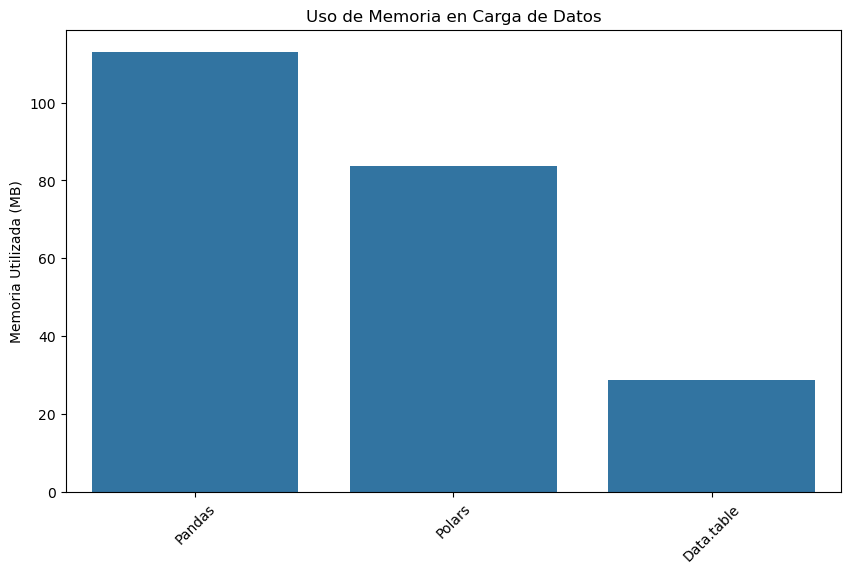

In [3]:
def measure_load_memory():
    results = []
    
    # Pandas
    initial_mem = get_process_memory()
    df_pandas = pd.read_csv('../data/sample_large.csv')
    pandas_mem = get_process_memory() - initial_mem
    results.append(('Pandas', pandas_mem))
    del df_pandas
    
    # Polars
    initial_mem = get_process_memory()
    df_polars = pl.read_csv('../data/sample_large.csv')
    polars_mem = get_process_memory() - initial_mem
    results.append(('Polars', polars_mem))
    del df_polars
    
    # Data.table
    initial_mem = get_process_memory()
    df_dt = dt.fread('../data/sample_large.csv')
    dt_mem = get_process_memory() - initial_mem
    results.append(('Data.table', dt_mem))
    del df_dt
    
    return results

memory_results = measure_load_memory()

# Visualizar resultados
plt.figure(figsize=(10, 6))
libraries, memories = zip(*memory_results)
sns.barplot(x=list(libraries), y=list(memories))
plt.title('Uso de Memoria en Carga de Datos')
plt.ylabel('Memoria Utilizada (MB)')
plt.xticks(rotation=45)
plt.show()

## 2. Pruebas de Transformación

Ahora comparemos el uso de memoria durante operaciones de transformación comunes.

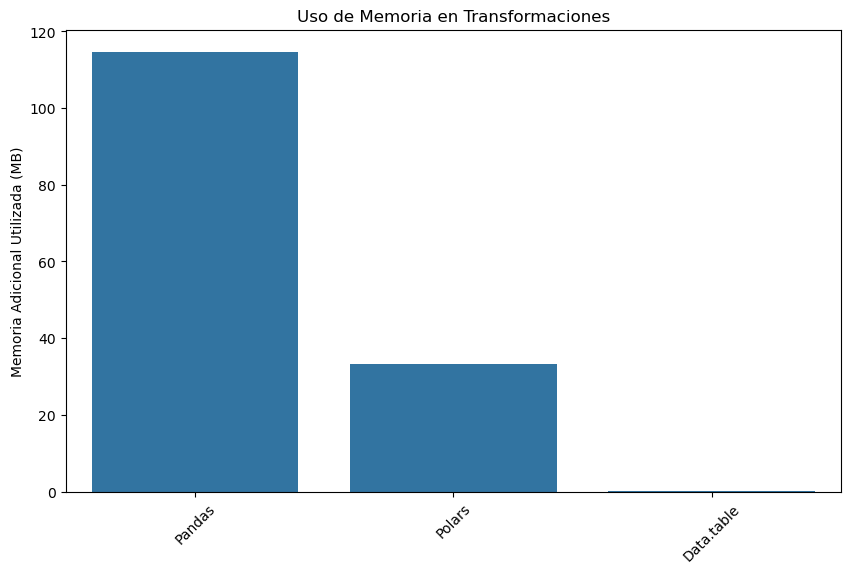

In [4]:
def benchmark_transformations():
    results = []
    
    # Pandas
    df_pandas = pd.read_csv('../data/sample_large.csv')
    initial_mem = get_process_memory()
    df_transformed = df_pandas.copy()
    df_transformed['valor_doble'] = df_transformed['valor_numerico'] * 2
    df_transformed['categoria_mod'] = df_transformed['categoria'] + '_mod'
    pandas_mem = get_process_memory() - initial_mem
    results.append(('Pandas', pandas_mem))
    del df_pandas, df_transformed
    
    # Polars
    df_polars = pl.read_csv('../data/sample_large.csv')
    initial_mem = get_process_memory()
    df_transformed = df_polars.with_columns([
        pl.col('valor_numerico').mul(2).alias('valor_doble'),
        pl.col('categoria').str.concat('_mod').alias('categoria_mod')
    ])
    polars_mem = get_process_memory() - initial_mem
    results.append(('Polars', polars_mem))
    del df_polars, df_transformed
    
    # Data.table
    df_dt = dt.fread('../data/sample_large.csv')
    initial_mem = get_process_memory()
    df_dt[:, dt.update(valor_doble=dt.f.valor_numerico * 2)]
    df_dt[:, dt.update(categoria_mod=dt.f.categoria + '_mod')]
    dt_mem = get_process_memory() - initial_mem
    results.append(('Data.table', dt_mem))
    del df_dt
    
    return results

transform_results = benchmark_transformations()

# Visualizar resultados
plt.figure(figsize=(10, 6))
libraries, memories = zip(*transform_results)
sns.barplot(x=list(libraries), y=list(memories))
plt.title('Uso de Memoria en Transformaciones')
plt.ylabel('Memoria Adicional Utilizada (MB)')
plt.xticks(rotation=45)
plt.show()

## 3. Pruebas de Agregación

Comparemos el uso de memoria durante operaciones de agregación.

C:\Users\Jordan\AppData\Local\Temp\ipykernel_31704\72933988.py:22: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  agg_result = df_polars.groupby('categoria').agg([


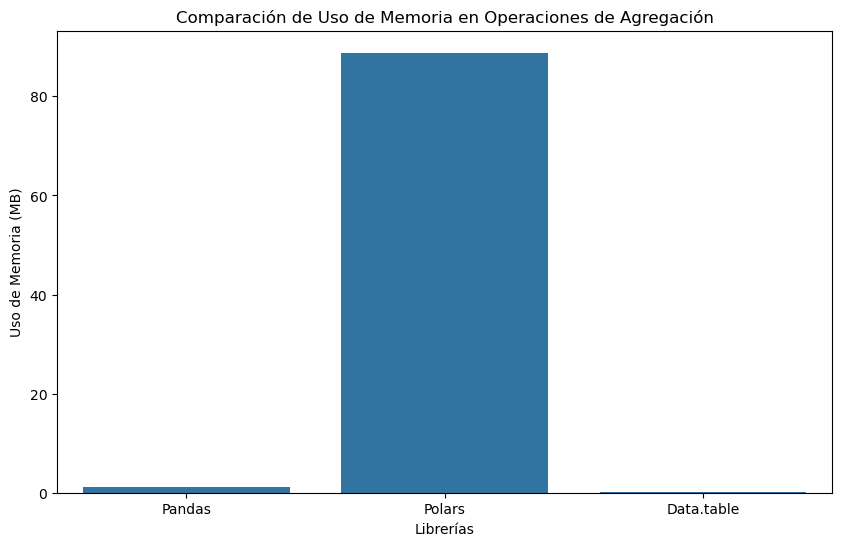

In [5]:

def get_process_memory():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)  # Retorna el uso de memoria en MB

def benchmark_aggregations():
    results = []
    
    # Pandas
    df_pandas = pd.read_csv('../data/sample_large.csv')
    initial_mem = get_process_memory()
    agg_result = df_pandas.groupby('categoria').agg({
        'valor_numerico': ['mean', 'std', 'count'],
        'valor_entero': ['sum', 'min', 'max']
    })
    pandas_mem = get_process_memory() - initial_mem
    results.append(('Pandas', pandas_mem))
    del df_pandas, agg_result
    
    # Polars
    df_polars = pl.read_csv('../data/sample_large.csv')
    initial_mem = get_process_memory()
    agg_result = df_polars.groupby('categoria').agg([
        pl.col('valor_numerico').mean().alias('mean_val'),
        pl.col('valor_numerico').std().alias('std_val'),
        pl.col('valor_numerico').count().alias('count_val'),
        pl.col('valor_entero').sum().alias('sum_int'),
        pl.col('valor_entero').min().alias('min_int'),
        pl.col('valor_entero').max().alias('max_int')
    ])
    polars_mem = get_process_memory() - initial_mem
    results.append(('Polars', polars_mem))
    del df_polars, agg_result
    
    # Data.table
    df_dt = dt.fread('../data/sample_large.csv')
    initial_mem = get_process_memory()
    agg_result = df_dt[:, {'mean_val': dt.mean(dt.f.valor_numerico),
                           'std_val': dt.sd(dt.f.valor_numerico),
                           'count': dt.count(),
                           'sum_int': dt.sum(dt.f.valor_entero),
                           'min_int': dt.min(dt.f.valor_entero),
                           'max_int': dt.max(dt.f.valor_entero)}, 
                        dt.by('categoria')]
    dt_mem = get_process_memory() - initial_mem
    results.append(('Data.table', dt_mem))
    del df_dt, agg_result
    
    return results

agg_results = benchmark_aggregations()

# Visualizar resultados
plt.figure(figsize=(10, 6))
libraries, memories = zip(*agg_results)
sns.barplot(x=list(libraries), y=list(memories))
plt.xlabel('Librerías')
plt.ylabel('Uso de Memoria (MB)')
plt.title('Comparación de Uso de Memoria en Operaciones de Agregación')
plt.show()
